# Imitation Learning for Portfolio Management

In [1]:
from model.supervised.imitation_optimal_action import *
from utils.data import create_optimal_imitation_dataset, create_imitation_dataset, read_stock_history, normalize
from __future__ import print_function
import random
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [15]:
# dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
target_stocks = ['AAPL', 'CMCSA', 'REGN']
target_history = np.empty(shape=(len(target_stocks), history.shape[1], history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :, :]

# test on 3 never seen stocks
test_stocks = ['GOOGL', 'DISH', 'ILMN']
test_history = np.empty(shape=(len(test_stocks), history.shape[1], history.shape[2]))
for i, stock in enumerate(test_stocks):
    test_history[i] = history[abbreviation.index(stock), :, :]

## Train optimal action given future observation

In [16]:
# build optimal model given future model
nb_classes = len(target_stocks) + 1
optimal_given_future_model = create_network_given_future(nb_classes)

Model load successfully


In [ ]:
# run this cell to train optimal action given future model
train_optimal_action_given_future_obs(model, target_history, target_stocks)

## Test learning from optimal action using future data: sanity check

In [18]:
(X_test, y_test), (_, _) = create_optimal_imitation_dataset(test_history)
Y_test = np_utils.to_categorical(y_test, 4)
loss, acc = optimal_given_future_model.evaluate(X_test, Y_test)
print('Testing result: loss - {}, accuracy - {}'.format(loss, acc))

1460/1460 [==============================] - 0s 56us/step
Testing result: loss - 0.0678725634842, accuracy - 0.98561643803


### Start to play in an environment with stocks we have never seen before

In [42]:
from environment.portfolio import PortfolioEnv
env = PortfolioEnv(test_history, test_stocks)

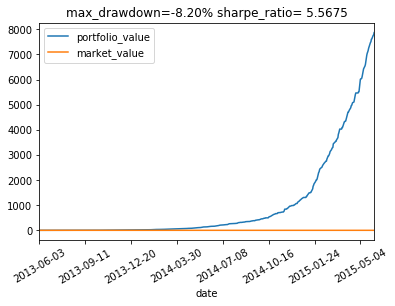

In [43]:
# buy and sell only 1 stock
done = False
observation, info = env.reset()
ground_truth_obs = info['next_obs']
close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.zeros((4,))
    current_action_index = optimal_given_future_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = 1.0
    observation, reward, done, info = env.step(action)
    ground_truth_obs = info['next_obs']
    close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
    close_open_ratio = normalize(close_open_ratio)
env.render()

### It turns out that using probability distribution sometimes yield higher return

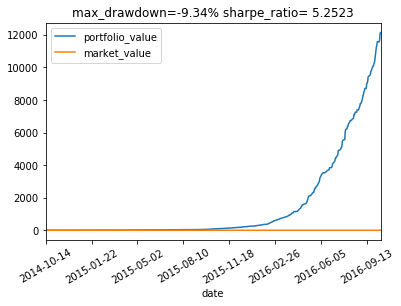

In [46]:
# buy and sell according to the probability, not the label
done = False
observation, info = env.reset()
ground_truth_obs = info['next_obs']
close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
close_open_ratio = normalize(close_open_ratio)
while not done:
    current_action = optimal_given_future_model.predict(close_open_ratio, verbose=False)
    current_action = np.squeeze(current_action, axis=0)
    observation, reward, done, info = env.step(current_action)
    ground_truth_obs = info['next_obs']
    close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
    close_open_ratio = normalize(close_open_ratio)
env.render()

## Train optimal action given history observation

In [49]:
# we need to test different window length
window_length = 3
# create model
optimal_given_past_model = create_network_give_past(nb_classes, window_length)

Model load successfully


In [ ]:
# run this cell to train the model. It would take 200 epoches to converge to around 45% validation accuracy
train_optimal_action_given_history_obs(model, target_history, target_stocks, window_length)

## Test optimal action given history observation

In [52]:
(X_test, y_test), (_, _) = create_imitation_dataset(test_history, window_length=window_length)
Y_test = np_utils.to_categorical(y_test, 4)
# increase a dimension of X_test for CNN
X_test = np.expand_dims(X_test, axis=-1)
loss, acc = optimal_given_past_model.evaluate(X_test, Y_test)
print('Testing result: loss - {}, accuracy - {}'.format(loss, acc))

1460/1460 [==============================] - 0s 77us/step
Testing result: loss - 1.24898497928, accuracy - 0.460273972603


In [53]:
env = PortfolioEnv(test_history, test_stocks, window_length=window_length)

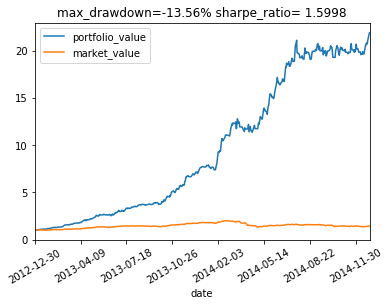

In [60]:
# buy and sell only 1 stock
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.zeros((4,))
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = 1.0
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()

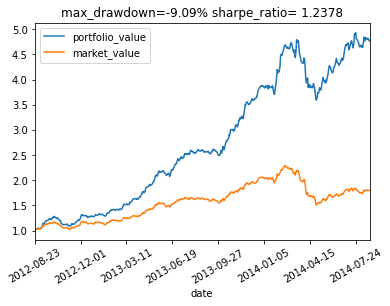

In [63]:
# buy and sell according to the probability, not the label
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
while not done:
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    close_open_ratio = normalize(close_open_ratio)
    current_action = optimal_given_past_model.predict(close_open_ratio, verbose=False)
    current_action = np.squeeze(current_action, axis=0)
    observation, reward, done, _ = env.step(current_action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
env.render()